<a href="https://colab.research.google.com/github/ambideXtrous9/PyTorch-Models/blob/main/Flickr27_Xception_PyTorch_Lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imutils
!pip install wget
!pip install split-folders
!pip install timm
!pip install pytorch-lightning

In [ ]:
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import splitfolders
from torch import nn
import numpy as np
import os
import timm
import wget
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks import TQDMProgressBar
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import cv2
import tensorflow as tf
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

## Downloading Dataset

In [ ]:
_URL = 'http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz'
wget.download(_URL)

'flickr_logos_27_dataset.tar.gz'

In [ ]:
!ls

flickr_logos_27_dataset.tar.gz	sample_data


In [ ]:
zip_dir = tf.keras.utils.get_file('./logo', origin=_URL, untar=True,extract=True)

101842944/101827904 [==============================] - 11s 0us/step


In [ ]:
import tarfile

fname = 'flickr_logos_27_dataset.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [ ]:
fname = 'flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [ ]:
src_dir = "flickr_logos_27_dataset_images"
dest = "LOGOS"

if not os.path.exists(dest):
    os.makedirs(dest)

## Preprocessing

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt", sep='\s+',header=None)

In [ ]:
df

,0,1,2,3,4,5,6
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93
...,...,...,...,...,...,...,...
4531,2126991906.jpg,Yahoo,6,15,6,253,54
4532,217288720.jpg,Yahoo,6,136,161,304,222
4533,2472817996.jpg,Yahoo,6,2,4,499,106
4534,2514220918.jpg,Yahoo,6,1,69,342,157


In [ ]:
X = df.iloc[:,0]
Y = df.iloc[:,1]

In [ ]:
dtdir = './flickr_logos_27_dataset_images/'

In [ ]:
im = df[0][0]

In [ ]:
size = df.iloc[:,3:]

In [ ]:
size

,3,4,5,6
0,38,12,234,142
1,242,208,413,331
2,13,5,89,60
3,43,122,358,354
4,83,63,130,93
...,...,...,...,...
4531,15,6,253,54
4532,136,161,304,222
4533,2,4,499,106
4534,1,69,342,157


In [ ]:
img = os.path.join(dtdir,im)

In [ ]:
size = size.values.tolist()

In [ ]:
size[0][0],size[0][1],size[0][2],size[0][3]

(38, 12, 234, 142)

(210, 280, 3)

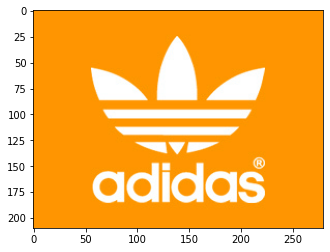

In [ ]:
image = cv2.imread(img)
plt.imshow(image)
image.shape

(130, 196, 3)

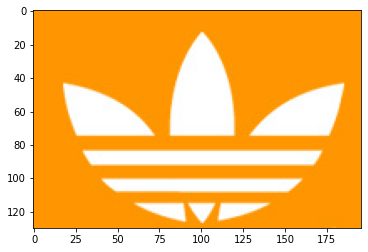

In [ ]:
image = cv2.imread(img)
image = image[size[0][1]:size[0][3],size[0][0]:size[0][2]]
plt.imshow(image)
image.shape

In [ ]:
query = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep='\s+',header=None)

In [ ]:
query

,0,1
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


(500, 437, 3)

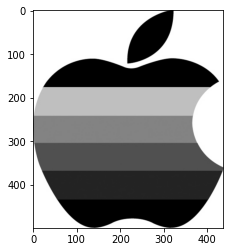

In [ ]:
img = os.path.join(dtdir,query[0][5])
image = cv2.imread(img)
plt.imshow(image)
image.shape

In [ ]:
y = list(set(list(Y)))
y.sort()

In [ ]:
for i in y:
    os.makedirs(os.path.join(dest,i))

In [ ]:
distractor = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt", sep='\s+',header=None)

In [ ]:
distractor

,0
0,http://farm2.static.flickr.com/1184/1013364004...
1,http://farm2.static.flickr.com/1108/1047095104...
2,http://farm2.static.flickr.com/1359/1076885577...
3,http://farm1.static.flickr.com/53/110432189_6d...
4,http://farm2.static.flickr.com/1144/1153048029...
...,...
4202,http://farm2.static.flickr.com/1254/889763557_...
4203,http://farm2.static.flickr.com/1308/901063602_...
4204,http://farm1.static.flickr.com/18/93551127_fed...
4205,http://farm2.static.flickr.com/1033/978252884_...


In [ ]:
HEIGHT = 224
WIDTH =  224
BS = 256

## Removing Corrupt Images 

In [ ]:
for i in range(len(X)):
    try:
        destrain = os.path.join(dest,Y[i])
        savepath = os.path.join(destrain,X[i])
        img  = os.path.join(dtdir,X[i])
        image = cv2.imread(img)
        image = image[size[i][1]:size[i][3],size[i][0]:size[i][2]]
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass

error
error
error
error
error


In [ ]:
A = query.iloc[:,0]
B = query.iloc[:,1]

In [ ]:
A

0      2403695909.jpg
1      2912587920.jpg
2      3441398196.jpg
3      4605630935.jpg
4      4606245138.jpg
            ...      
265    3480640208.jpg
266    3486224308.jpg
267    3486430785.jpg
268    3490185235.jpg
269    3490913574.jpg
Name: 0, Length: 270, dtype: object

In [ ]:

for i in range(len(A)):
    try:
        destrain = os.path.join(dest,B[i])
        savepath = os.path.join(destrain,A[i])
        img  = os.path.join(dtdir,A[i])
        image = cv2.imread(img)
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


In [ ]:
imagePaths = list(paths.list_images(dest))

LOGOS/Heineken/4458514217.jpg


(224, 224, 3)

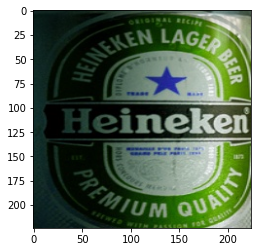

In [ ]:
img = imagePaths[40]
print(img)
image = cv2.imread(img)
plt.imshow(image)
image.shape

## Train Val Split

In [ ]:
path = 'LOGOS'

In [ ]:
splitfolders.ratio(path, output="data", seed=42, ratio=(0.8,0.2))

Copying files: 944 files [00:00, 7671.72 files/s]


## Image Augmentation

In [ ]:
# initialize our data augmentation functions
resize = transforms.Resize(size=(WIDTH,HEIGHT))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)
coljtr = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1)
raf = transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0)
rrsc = transforms.RandomResizedCrop(size=WIDTH, scale=(0.8, 1.0))
ccp  = transforms.CenterCrop(size=WIDTH)  # Image net standards
nrml = transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])  # Imagenet standards

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1421: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1436: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  "The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. "


In [ ]:
# initialize our training and validation set data augmentation
# pipeline
trainTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])
valTransforms = transforms.Compose([resize,hFlip,vFlip,rotate,raf,rrsc,ccp,coljtr,transforms.ToTensor(),nrml])

In [ ]:
# initialize the training and validation dataset
print("[INFO] loading the training and validation dataset...")
trainDataset = ImageFolder(root='./data/train',transform=trainTransforms)
valDataset = ImageFolder(root='./data/val', transform=valTransforms)
print("[INFO] training dataset contains {} samples...".format(len(trainDataset)))
print("[INFO] validation dataset contains {} samples...".format(len(valDataset)))

[INFO] loading the training and validation dataset...
[INFO] training dataset contains 755 samples...
[INFO] validation dataset contains 189 samples...


## Model

In [ ]:
class LitNeuralNet(pl.LightningModule):
    def __init__(self,num_classes):
        super(LitNeuralNet, self).__init__()
        
        
        self.model = timm.create_model('xception', pretrained=True)
        self.model.aux_logits=False

        # Freeze training for all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.fc = nn.Sequential(
                      nn.Linear(self.model.fc.in_features, 256), 
                      nn.Dropout(0.5),
                      nn.ReLU(inplace=True),
                      nn.BatchNorm1d(256),
                      nn.Linear(256, num_classes),
                      nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        images, labels = batch
        # Forward pass
        outputs = self.model(images)
        lossfn = nn.NLLLoss()
        loss = lossfn(outputs, labels)
        tensorboard_logs = {'train_loss': loss}
        # use key 'log'
        return {"loss": loss, 'log': tensorboard_logs}

    # define what happens for testing here

    def train_dataloader(self):
        trainDataLoader = DataLoader(trainDataset, num_workers=2,batch_size=BS, shuffle=True)

        return trainDataLoader

    def val_dataloader(self):
        valDataLoader = DataLoader(valDataset, num_workers=2,batch_size=BS,shuffle=False)
        
        return valDataLoader
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch
        # Forward pass
        outputs = self.model(images)
        lossfn = nn.NLLLoss()   
        loss = lossfn(outputs, labels)
        self.log("val_loss", loss)
        return {"val_loss": loss}
        
    def validation_epoch_end(self, outputs):
        # outputs = list of dictionaries
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'avg_val_loss': avg_loss}
        # use key 'log'
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters())


In [ ]:
# seeding for torch, numpy, stdlib random, including DataLoader workers!
seed_everything(123, workers=True)

early_stopping = EarlyStopping(
    monitor="val_loss",
    stopping_threshold=1e-4,
    divergence_threshold=9.0,
    check_finite=True)

Global seed set to 123


In [ ]:
!pip install tensorboardcolab

  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3859 sha256=c723012febd13b7c8ac242143e78d404446ea869f739d9da345ab66f002c7a3e
  Stored in directory: /root/.cache/pip/wheels/69/4e/4a/1c6c267395cb10edded1050df12af165d3254cfce324e80941
Successfully built tensorboardcolab


In [ ]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback

tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://a829-35-230-48-32.ngrok.io


In [ ]:
model = LitNeuralNet(num_classes=len(trainDataset.classes))
trainer = Trainer(accelerator='gpu', devices=1,max_epochs=20,log_every_n_steps=2,callbacks=[early_stopping,TensorBoardColabCallback(tbc)])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params
-----------------------------------
0 | model | Xception | 21.3 M
-----------------------------------
531 K     Trainable params
20.8 M    Non-trainable params
21.3 M    Total params
85.356    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

## Accuracy - Loss Plot

## Prediction On Test Images

In [ ]:
testimage = list(paths.list_images('./flickr_logos_27_dataset_images'))

In [ ]:
def predimg(path):
    from PIL import Image
    image = Image.open(path)
    plt.imshow(image)
    plt.axis("off")
    plt.show() 
    model.eval()
    with torch.no_grad():
      img =  load_img(path)
      mean = [0.485, 0.456, 0.406] 
      std = [0.229, 0.224, 0.225]
      transform_norm = transforms.Compose([transforms.ToTensor(), 
      transforms.Resize((224,224)),transforms.Normalize(mean, std)])
      img_normalized = transform_norm(img).float()
      img_normalized = img_normalized.unsqueeze_(0)
      img = torch.from_numpy(np.asarray(img)).permute(2, 0, 1)
      img = img_normalized#.to(device)
      output = model(img)
      output = torch.exp(output)
      #print(output)
      index = output.data.cpu().numpy().argmax()
      result = list(np.around(output.data.cpu().numpy()*100,1))
      print(result)
      print("PREDICTED CLASS = ",trainDataset.classes[index])

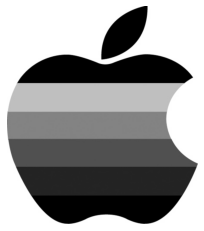

[array([ 0.5, 82.4,  0.4,  0.6,  0.1,  0.2,  0.2,  0.2,  0.4,  0.2,  0.4,
        0.2,  0.3,  0.6,  0.1,  2. ,  2.5,  0.7,  0.7,  4.3,  0.2,  0.6,
        0.1,  0.1,  0.4,  1.1,  0.6], dtype=float32)]
PREDICTED CLASS =  Apple


In [ ]:
predimg(testimage[8])

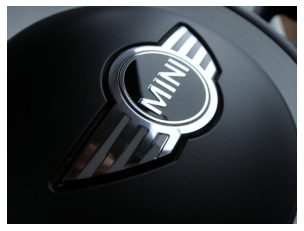

[array([ 2.4,  2.7, 12.6,  1.8,  1.8,  1.6,  1. ,  2.3,  3. ,  1.3,  4.2,
        2.2,  0.9,  2.3, 36.8,  0.7,  1.8,  2.3,  1.2,  1.7,  1.8,  2.8,
        3.8,  0.7,  0.8,  4.4,  1.1], dtype=float32)]
PREDICTED CLASS =  Mini


In [ ]:
predimg(testimage[2])

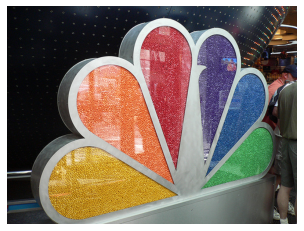

[array([ 1.1,  0.7,  0.4,  2.8,  4. ,  0.6,  0.2,  0.7,  0.8,  0.6,  0.4,
        1.4,  0.3,  6.3,  0.2, 70.1,  0.8,  0.6,  1.9,  0.5,  1.1,  1.6,
        0.8,  0.3,  0.4,  0.5,  0.7], dtype=float32)]
PREDICTED CLASS =  Nbc


In [ ]:
predimg(testimage[16])

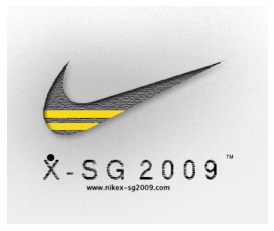

[array([ 1. ,  6.1,  0.4,  3.8,  2.2,  0.8,  0.3,  0.5,  0.6,  0.4,  0.2,
        0.7,  0.8,  1. ,  0.6,  1.2, 65.3,  4.9,  0.8,  1. ,  0.8,  1. ,
        0.5,  0.6,  1.2,  0.7,  2.6], dtype=float32)]
PREDICTED CLASS =  Nike


In [ ]:
predimg(testimage[20])

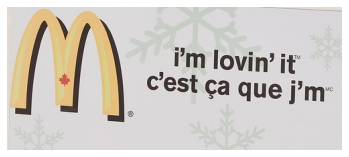

[array([14.1,  0.4,  1.2,  1.8,  2.8, 10.4,  1.9,  0.6,  0.4,  1.6,  0.6,
        2.2,  1.6, 32.1,  1.8,  0.7,  5.6,  0.2,  0.6,  0.6,  1.4,  0.8,
        1.7,  0.8,  2.1,  1.9, 10.2], dtype=float32)]
PREDICTED CLASS =  McDonalds


In [ ]:
predimg(testimage[22])

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

No known TensorBoard instances running.
